In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Simulación del tiempo muerto en detectores

El objetivo de este trabajo es simular distintos modelos de tiempo muerto, aplicados a un tren de pulsos proveniente de un proceso Poissoniano.

Primero se simulará el tiempo de llegada de pulsos de un proceso Poissoniano (en donde el tiempo entre pulsos sigue una distribución exponencial).

Luego se aplicarán distintos modelos de tiempo muerto y se analizarán las características principales de los resultados obtenidos.

## 1) Simulación de tiempos de llegada de pulsos

Tasa de cuentas teórica: 100.00 cps


<IPython.core.display.Javascript object>


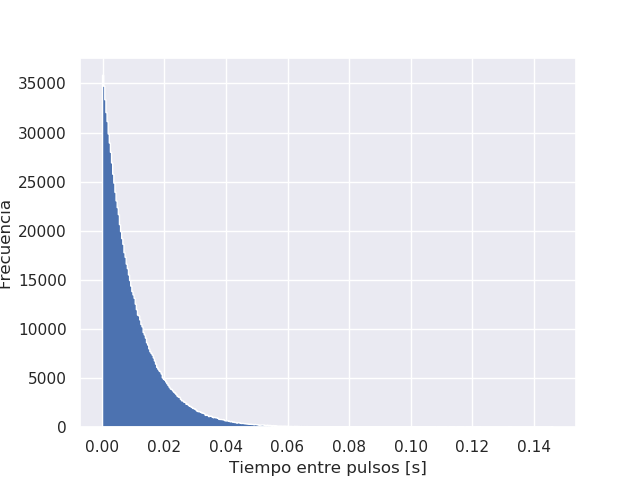

In [2]:
# Parámetro de la distribución exponencial [1/s]
LAMBDA = 0.01
print('Tasa de cuentas teórica: {:.2f} cps'.format(1/LAMBDA))

# Genero un vector con números que siguen una pdf exponencial
#
# Cantidad de datos generados
NTOT = 1000000
np.random.seed(1)
int_pulsos = np.random.exponential(LAMBDA, NTOT)

# Grafico los datos generados
fig, ax = plt.subplots(1, 1)
_ = ax.hist(int_pulsos, 400, histtype='stepfilled')
ax.set_xlabel('Tiempo entre pulsos [s]')
ax.set_ylabel('Frecuencia');

### Obtención de la tasa de cuentas

La mayoría de las veces uno sólo tiene acceso a la cantidad de cuentas en un determinado intervalo temporal.

Si se normaliza por la duración del intervalo se obtiene la tasa de cuentas.

<IPython.core.display.Javascript object>


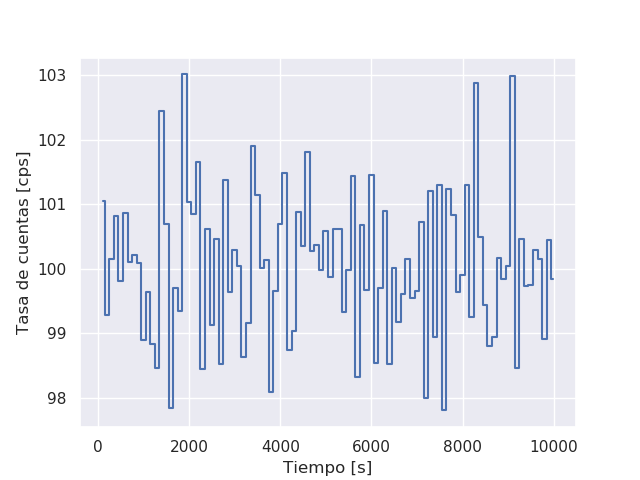

In [3]:
# Construyo un vector con tiempos de cada pulso
pulsos = np.cumsum(int_pulsos)
# Realizo un binneado para calcular las cuentas en cada intervalo temporal
hist, bins = np.histogram(pulsos, 100)
# Uso bines centrados
cent_bins = bins[:-1] + np.diff(bins)

# Calculo la tasa de cuentas de cada intervalo
tasa = hist/np.diff(bins)
# Gráfico de los intervalos
fig, ax = plt.subplots(1, 1)
ax.plot(cent_bins, tasa, drawstyle='steps-mid')
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel('Tasa de cuentas [cps]');

In [4]:
tasa.mean()

100.05896660632105

## 2) Simulación de distintos modelos de tiempo muerto

Primero se definen las dos funciones que simulan el tiempo muerto paralizable y no paralizable.

Ambas toman los tiempos de llegada de los pulsos.

In [5]:
def genera_paralizable(data, tau_p, verbose=True):
    """ 
    Función para generar un tiempo muerto paralizable en los datos

    Parámetros
    ----------
        datos : array
            Tiempo de llegada de cada pulso
        tau :
            Tiempo muerto no-paralizable que se simulará

    Resultados
    ----------
        datos_np_simulados : array
            Pulsos con timestaming con el tiempo muerto np ya simulado.

    """
    # Calcula tiempo entre pulsos
    dts = np.diff(data)
    # Busca los índices cuyo dt sea menor al tiempo muerto
    # (se le suma uno porque con numpy.diff() se quita un punto)
    indx_to_remove = np.where(dts <= tau_p)[0] + 1 
    # Se quitan todos los pulsos
    datos_p_simulados = np.delete(data, indx_to_remove)

    if verbose:
        print('Simulación tiempo muerto paralizable:')
        print('Pulsos originales: {}'.format(data.size))
        print('Pulsos eliminados: {}'.format(indx_to_remove.size))
        print('Pulsos restantes: {}'.format(datos_p_simulados.size))
        print(80*'-')

    return datos_p_simulados

In [6]:
def genera_no_paralizable(data, tau_np, verbose=True):
    """ 
    Función para generar un tiempo muerto no paralizable en los datos

    Parámetros
    ----------
        datos : array
            Tiempo de llegada de cada pulso
        tau :
            Tiempo muerto paralizable que se simulará

    Resultados
    ----------
        datos_np_simulados : array
            Tiempo de llegada de cada pulso con el tiempo muerto np ya simulado

    """
    # Array donde pongo un flag a cada pulso que se eliminará
    _flagged = data.copy()
    N_tot = data.size
    flag = -1
    # Loop que recorre pulsos sin flag (pues 'pass')
    for i in range(N_tot):
        if _flagged[i] != flag:
            for j in range(1, N_tot-i):
                if _flagged[i+j] - _flagged[i] <= tau_np:
                    _flagged[i+j] = flag
                else:
                    break
        else:
            pass
    # Lo convierto a array
    _flagged = np.asarray(_flagged)
    # Busco elementos con el flag
    indx_to_remove = np.where(_flagged==flag)[0]
    # Elimino elementos con el flag
    datos_np_simulados = np.delete(_flagged, indx_to_remove)
   
    if verbose:
        print('Simulación tiempo muerto no paralizable:')
        print('Pulsos originales: {}'.format(data.size))
        print('Pulsos eliminados: {}'.format(indx_to_remove.size))
        print('Pulsos restantes: {}'.format(datos_np_simulados.size))
        print(80*'-')
    
    return datos_np_simulados

Defino los tiempos muertos

In [7]:
# Tiempo muerto no paralizable [s]
TAU_NP = 1e-2
# Tiempo muerto paralizable [s]
TAU_P = 1e-2

Se simula el tiempo muerto no paralizable:

In [8]:
pulsos_np = genera_no_paralizable(pulsos, TAU_NP)
int_pulsos_np = np.diff(pulsos_np)

Simulación tiempo muerto no paralizable:
Pulsos originales: 1000000
Pulsos eliminados: 499989
Pulsos restantes: 500011
--------------------------------------------------------------------------------


Se simula el tiempo muerto paralizable

In [9]:
pulsos_p = genera_paralizable(pulsos, TAU_P)
int_pulsos_p = np.diff(pulsos_p)

Simulación tiempo muerto paralizable:
Pulsos originales: 1000000
Pulsos eliminados: 631686
Pulsos restantes: 368314
--------------------------------------------------------------------------------


Se grafican los histogramas de tiempos entre pulsos

<IPython.core.display.Javascript object>


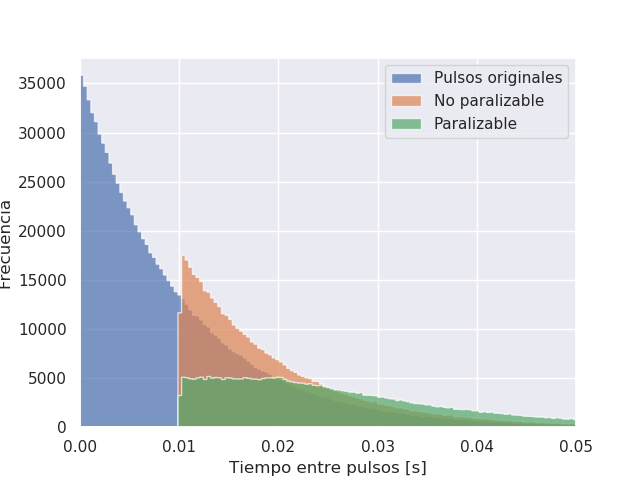

In [10]:
fig, ax = plt.subplots(1, 1)

hist, bins, _ = ax.hist(int_pulsos, 400, histtype='stepfilled', alpha=0.7, label='Pulsos originales') 
ax.hist(int_pulsos_np, bins, histtype='stepfilled', alpha=0.7, label='No paralizable') 
ax.hist(int_pulsos_p, bins, histtype='stepfilled', alpha=0.7, label='Paralizable') 

ax.legend()
ax.set_xlabel('Tiempo entre pulsos [s]')
ax.set_ylabel('Frecuencia')
ax.set_xlim(0, 0.05)
plt.show()

### ¿Cómo se modifican las tasas de cuentas?

<IPython.core.display.Javascript object>


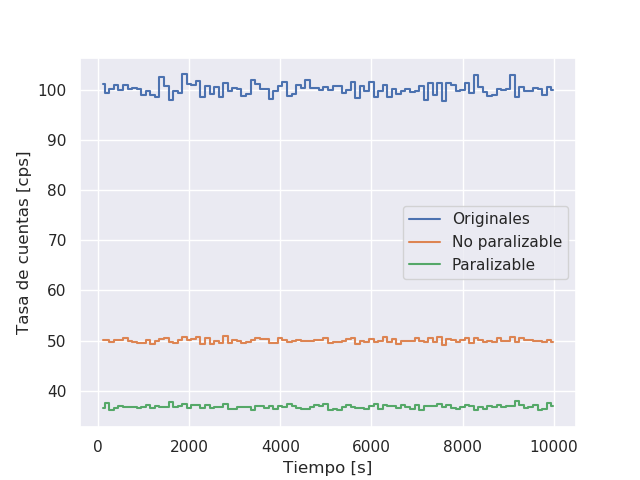

Valor medio Originales: 100.06
Valor medio No paralizable: 50.03
Valor medio Paralizable: 36.85


In [11]:
fig, ax = plt.subplots(1, 1)
datas = [int_pulsos, int_pulsos_np, int_pulsos_p]
labels = ['Originales', 'No paralizable', 'Paralizable']

for data, label in zip(datas, labels):
    _pulsos = np.cumsum(data)
    hist, bins = np.histogram(_pulsos, 100)
    cent_bins = bins[:-1] + np.diff(bins)
    tasa = hist/np.diff(bins)
    ax.plot(cent_bins, tasa, drawstyle='steps-mid', label=label)
    print('Valor medio {}: {:.2f}'.format(label, tasa.mean()))
ax.legend();
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel('Tasa de cuentas [cps]');

Los valores teóricos eran:

* Tiempo muerto no paralizable
    \begin{equation}
        m = \frac{n}{1+n\tau}
    \end{equation}
        
* Tiempo muerto paralizable
    \begin{equation}
        m = n e^{-n\tau}
    \end{equation}

In [12]:
def teorica_np(real, tau):
    """ Calcula tasa teórica con modelo no-paralizable"""
    return real / (1 + real * tau)
def teorica_p(real, tau):
    """ Calcula tasa teórica con modelo paralizable"""
    return real * np.exp(-real * tau)

In [13]:
teorica_np(100, TAU_NP), teorica_p(100, TAU_P)

(50.0, 36.787944117144235)

# Simulación para distintas tasas de cuentas

In [14]:
def tiempos_a_tasas(tiempos):
    """ Obtengo tasa de cuentas a partir de tiempo de cada pulsos"""
    # Realizo un binneado para calcular las cuentas en cada intervalo temporal
    _hist, _bins = np.histogram(tiempos, 100)
    # Calculo la tasa de cuentas de cada intervalo
    tasa = _hist/np.diff(_bins)   
    return tasa.mean()

# Tasas de cuentas teóricas para simular
tasas_teoricas = np.linspace(1, 1000, 100)

# Tiempo muerto no paralizable [s]
TAU_NP = 1e-2
# Tiempo muerto paralizable [s]
TAU_P = 1e-2
# Cantidad de puntos a simular para cada tasa
NTOT = 10000
# Semilla del generador de números pseudo-aleatorios
np.random.seed(1)

# Vector de tasas reales simuladas
tasas_sim = []
# Vector de tasas detectadas con tiempo muerto no paralizable
tasas_np = []
# Vector de tasas detectadas con tiempo muerto paralizable
tasas_p = []

for tasa in tasas_teoricas:
    # Genero los pulsos reales
    int_pulsos = np.random.exponential(1/tasa, NTOT)
    pulsos = np.cumsum(int_pulsos)
    # Calculo la tasa real simulada
    tasas_sim.append(tiempos_a_tasas(pulsos))
    
    # Aplico un tiempo muerto no paralizable
    pulsos_np = genera_no_paralizable(pulsos, TAU_NP, False)
    # Calculo la tasa con tiempo muerto np
    tasas_np.append(tiempos_a_tasas(pulsos_np))
    
    # Aplico un tiempo muerto paralizable
    pulsos_p = genera_paralizable(pulsos, TAU_P, False)
    # Calculo la tasa con tiempo muerto n
    tasas_p.append(tiempos_a_tasas(pulsos_p))

# Convierto a numpy arrays
tasas_sim = np.asarray(tasas_sim)
tasas_np = np.asarray(tasas_np)
tasas_p = np.asarray(tasas_p)

<IPython.core.display.Javascript object>


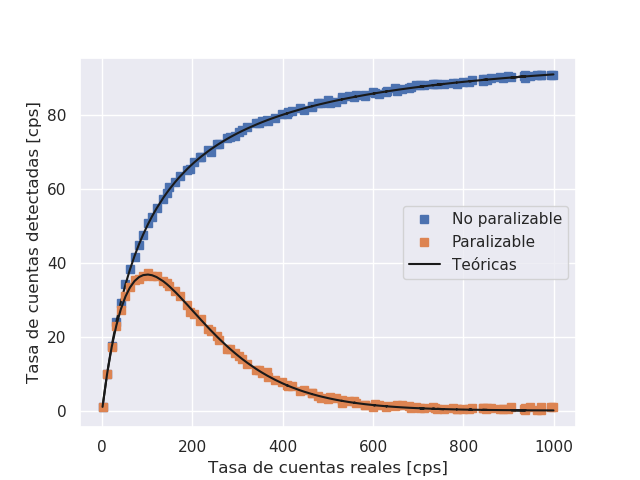

In [15]:
fig, ax = plt.subplots(1, 1)

ax.plot(tasas_sim, tasas_np, 's', label='No paralizable')
ax.plot(tasas_sim, teorica_np(tasas_sim, TAU_NP), 'k')
ax.plot(tasas_sim, tasas_p, 's', label='Paralizable')
ax.plot(tasas_sim, teorica_p(tasas_sim, TAU_P), 'k', label='Teóricas')
ax.set_xlabel('Tasa de cuentas reales [cps]')
ax.set_ylabel('Tasa de cuentas detectadas [cps]')
ax.legend();

## Tarea:

Repetir el análisis pero ahora considerando distintos tiempos muertos en serie:

1. Paralizable + No-paralizable
2. No-paralizable + Paralizable